In [31]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import saraRC1 as sara

In [2]:
im = cv2.imread('./images/books.jpeg')
grid_size = 8
saliency_maps ={}
sara_heatmaps = {}

**Multi-Plot**

In [32]:
img_path = './images'
imgs = []

for root, dirs, files in os.walk(img_path):
    for file in files:
        imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB))

In [33]:
seg_dim = 8
saliency_maps = {}
sara_heatmaps = {}
sara_lists = {}

--> Processing image 1 of 4 (itti) [6.25%]
--> Processing image 1 of 4 (deepgaze) [12.5%]
Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


--> Processing image 1 of 4 (fpn) [18.75%]
--> Processing image 1 of 4 (emlnet) [25.0%]
Model loaded emlnet/backbone/res_imagenet.pth
Model loaded emlnet/backbone/res_places.pth
Loaded decoder emlnet/backbone/res_decoder.pth
--> Processing image 2 of 4 (itti) [31.25%]
--> Processing image 2 of 4 (deepgaze) [37.5%]
Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


--> Processing image 2 of 4 (fpn) [43.75%]
--> Processing image 2 of 4 (emlnet) [50.0%]
Model loaded emlnet/backbone/res_imagenet.pth
Model loaded emlnet/backbone/res_places.pth
Loaded decoder emlnet/backbone/res_decoder.pth
--> Processing image 3 of 4 (itti) [56.25%]
--> Processing image 3 of 4 (deepgaze) [62.5%]
Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


--> Processing image 3 of 4 (fpn) [68.75%]
--> Processing image 3 of 4 (emlnet) [75.0%]
Model loaded emlnet/backbone/res_imagenet.pth
Model loaded emlnet/backbone/res_places.pth
Loaded decoder emlnet/backbone/res_decoder.pth
--> Processing image 4 of 4 (itti) [81.25%]
--> Processing image 4 of 4 (deepgaze) [87.5%]
Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\matth/.cache\torch\hub\pytorch_vision_v0.6.0


--> Processing image 4 of 4 (fpn) [93.75%]
--> Processing image 4 of 4 (emlnet) [100.0%]
Model loaded emlnet/backbone/res_imagenet.pth
Model loaded emlnet/backbone/res_places.pth
Loaded decoder emlnet/backbone/res_decoder.pth


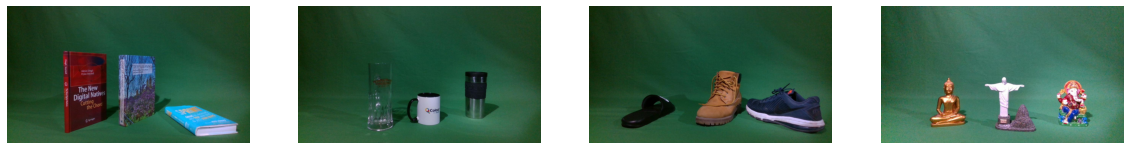

In [34]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.tight_layout()

generators = ['itti', 'deepgaze', 'fpn', 'emlnet']

g = 1

for i, im in enumerate(imgs):
    if i not in saliency_maps:
        saliency_maps[i] = {}
        sara_heatmaps[i] = {}
        sara_lists[i] = {}

    for generator in generators:
        percent = round(g/(len(imgs)*len(generators))*100, 2)
        
        print(f'--> Processing image {i+1} of {len(imgs)} ({generator}) [{percent}%]')

        saliency_maps[i][generator] = sara.return_saliency(im.copy(), generator=generator)
        sara.reset()

        sara_heatmaps[i][generator], sara_lists[i][generator] = sara.return_sara(im.copy(), seg_dim, saliency_map=saliency_maps[i][generator])
        sara.reset()

        g += 1
    
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(im)
    plt.axis('off')


**<h2>Spearman Correlation (Metric for Ranks)</h2>**

In [61]:
import scipy.stats as sc

ranks = {}
for key, value in sara_lists.items():
    ranks[key] = [i[0] for i in value]

print(ranks)
spr = sc.spearmanr(ranks["itti"], ranks["deepgaze"])
print(spr)


{'itti': [12, 4, 20, 21, 6, 13, 18, 3, 5, 14, 11, 19, 26, 48, 56, 17, 10, 29, 15, 25, 7, 22, 9, 24, 1, 2, 40, 32, 23, 30, 27, 8, 33, 63, 28, 16, 31, 39, 0, 47, 62, 55, 61, 37, 58, 59, 60, 53, 50, 57, 52, 36, 43, 34, 44, 51, 35, 38, 41, 49, 42, 46, 45, 54], 'deepgaze': [17, 22, 19, 9, 21, 18, 10, 6, 20, 1, 5, 7, 15, 31, 23, 14, 24, 48, 12, 13, 40, 16, 11, 4, 8, 32, 29, 2, 0, 3, 56, 63, 30, 25, 39, 47, 26, 61, 55, 52, 57, 58, 51, 53, 60, 59, 27, 45, 44, 62, 43, 41, 28, 50, 33, 49, 37, 54, 35, 42, 46, 36, 34, 38], 'fpn': [7, 1, 2, 0, 15, 3, 4, 6, 5, 23, 17, 13, 21, 29, 31, 22, 9, 10, 12, 8, 16, 20, 14, 11, 18, 19, 25, 30, 24, 32, 39, 47, 63, 40, 48, 27, 56, 28, 26, 33, 55, 61, 60, 52, 59, 51, 62, 44, 43, 35, 53, 36, 54, 57, 58, 49, 41, 37, 34, 50, 45, 38, 42, 46], 'emlnet': [0, 56, 8, 7, 1, 48, 16, 6, 2, 63, 15, 9, 40, 24, 5, 3, 32, 4, 23, 17, 14, 10, 31, 13, 11, 12, 22, 18, 21, 19, 61, 20, 62, 59, 57, 55, 29, 58, 30, 60, 39, 25, 47, 26, 51, 52, 27, 28, 53, 49, 54, 37, 45, 41, 44, 33, 43,

**<h2>Normalizing Spearman Correlation</h2>**

In [62]:
def get_norm_spr(spr_value):
    #       m - r_min
    # m -> ---------------- x (t_max - t_min) + t_min
    #       r_max - r_min
    #
    # m = measure value
    # r_min = min range of measurement
    # r_max = max range of measurement
    # t_min = min range of desired scale
    # t_max = max range of desired scale

    r_min = -1
    r_max = 1

    norm_spr = (spr_value - r_min) / (r_max - r_min)

    return norm_spr

In [64]:
norm_spr = get_norm_spr(spr.correlation)
print(norm_spr)

0.7540750915750916
